In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm, expon, beta, uniform, triang, kstest

# Initial data exploration
## Ore grade
### Load an plot distributions

In [4]:
df_nickel = pd.read_excel(r'data/data_metals_pellan.xlsx', sheet_name='Mudd2014_ni')
df_copper = pd.read_excel(r'data/data_metals_pellan.xlsx', sheet_name='Mudd2018_cop')

In [8]:
def plot_grade_statistics(df, grade_column, mineral, country=None):
    """
    Plots two subplots: (1) a histogram of ore grade data and (2) a KDE distribution with key statistics
    for a specific mineral. Returns a summary DataFrame with mean, min, max, and standard deviation.

    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - mineral (str): The mineral name (e.g., "Nickel" or "Copper").
    - country (str, optional): Specific country to filter the data by. Defaults to "All" if None.

    Returns:
    - pd.DataFrame: Summary of statistics including Mean, Min, Max, and Std Dev for the selected grade column.
    """
    # Filter by country if specified
    if country:
        df = df[df['Country'] == country]
    else:
        country = "All"  # Set country to "All" if no specific country is provided

    # Calculate statistics
    mean_val = df[grade_column].mean()
    min_val = df[grade_column].min()
    max_val = df[grade_column].max()
    std_dev = df[grade_column].std()

    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1.2]})

    # Plot histogram on the first subplot
    sns.histplot(df[grade_column], kde=False, color='lightgrey', bins=15, stat='count', ax=axes[0])
    axes[0].set_title(f'{mineral} - {grade_column} Histogram' + (f' for {country}' if country else ''))
    axes[0].set_xlabel(grade_column)
    axes[0].set_ylabel('Count')

    # Plot KDE on the second subplot with key statistics
    sns.kdeplot(df[grade_column], fill=True, color='skyblue', ax=axes[1], label="KDE", linewidth=2,
                clip=(min_val, max_val))
    axes[1].axvline(mean_val, color='green', linestyle='--', label=f'Mean: {mean_val:.4f}')
    axes[1].axvline(min_val, color='blue', linestyle='--', label=f'Min: {min_val:.4f}')
    axes[1].axvline(max_val, color='red', linestyle='--', label=f'Max: {max_val:.4f}')
    axes[1].axvline(mean_val + std_dev, color='purple', linestyle=':',
                    label=f'Mean + Std Dev: {(mean_val + std_dev):.4f}')
    axes[1].axvline(mean_val - std_dev, color='purple', linestyle=':',
                    label=f'Mean - Std Dev: {(mean_val - std_dev):.4f}')
    axes[1].set_title(f'{mineral} - {grade_column} KDE Distribution' + (f' for {country}' if country else ''))
    axes[1].set_xlabel(grade_column)
    axes[1].set_ylabel('Density')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


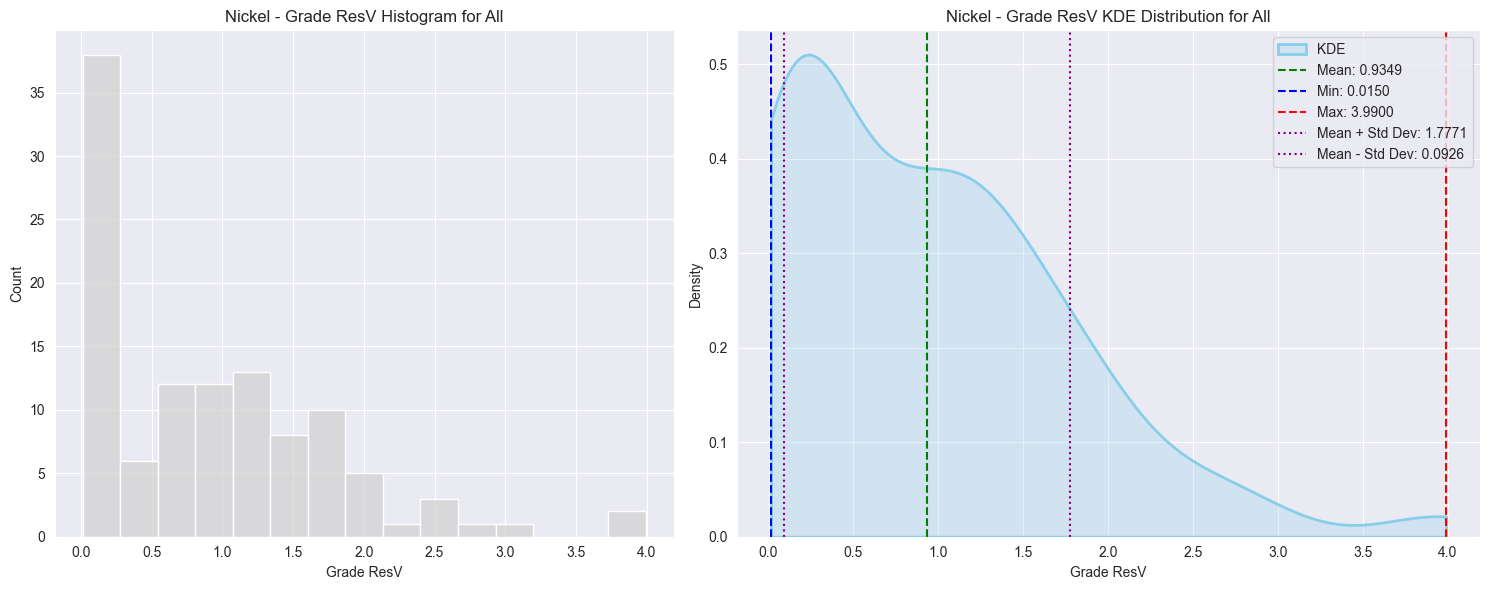

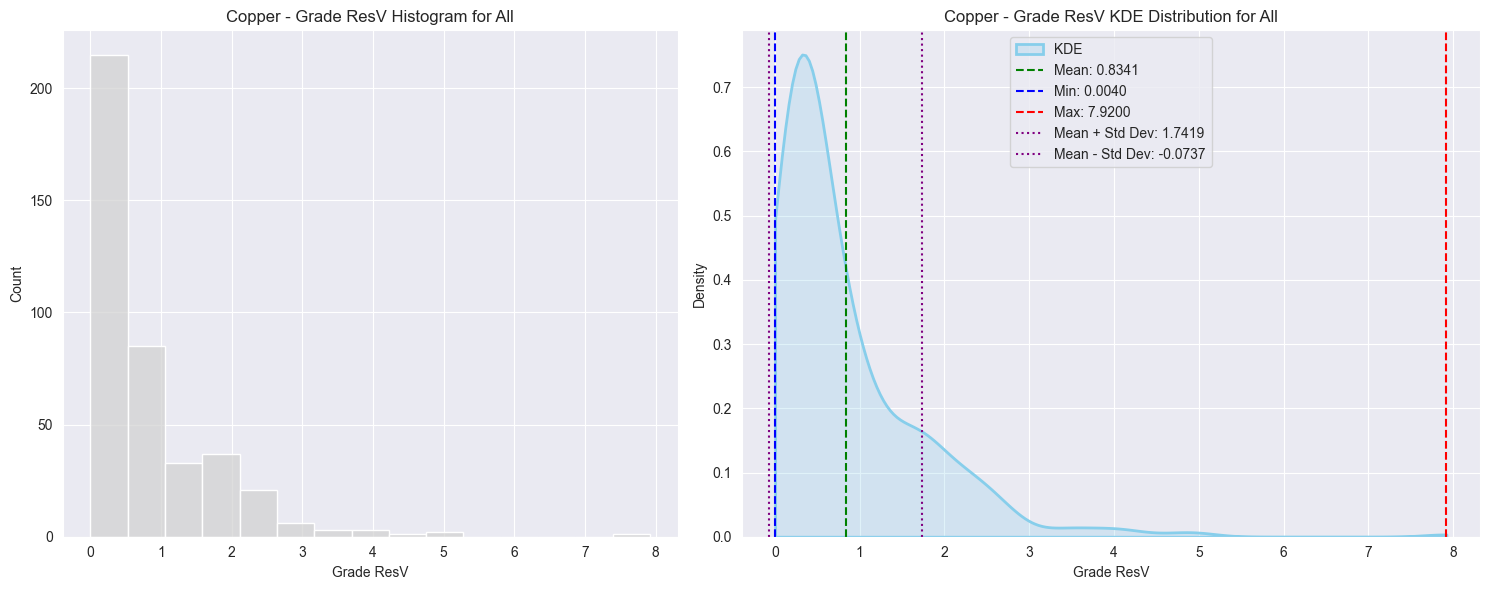

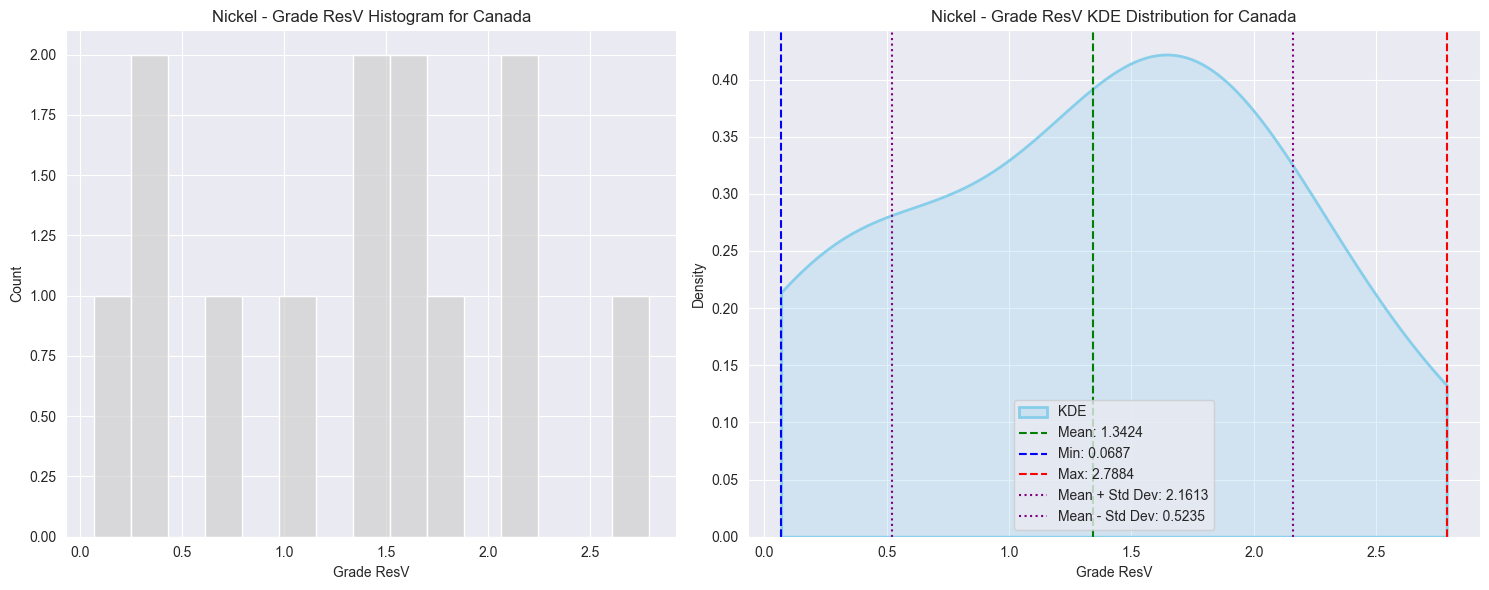

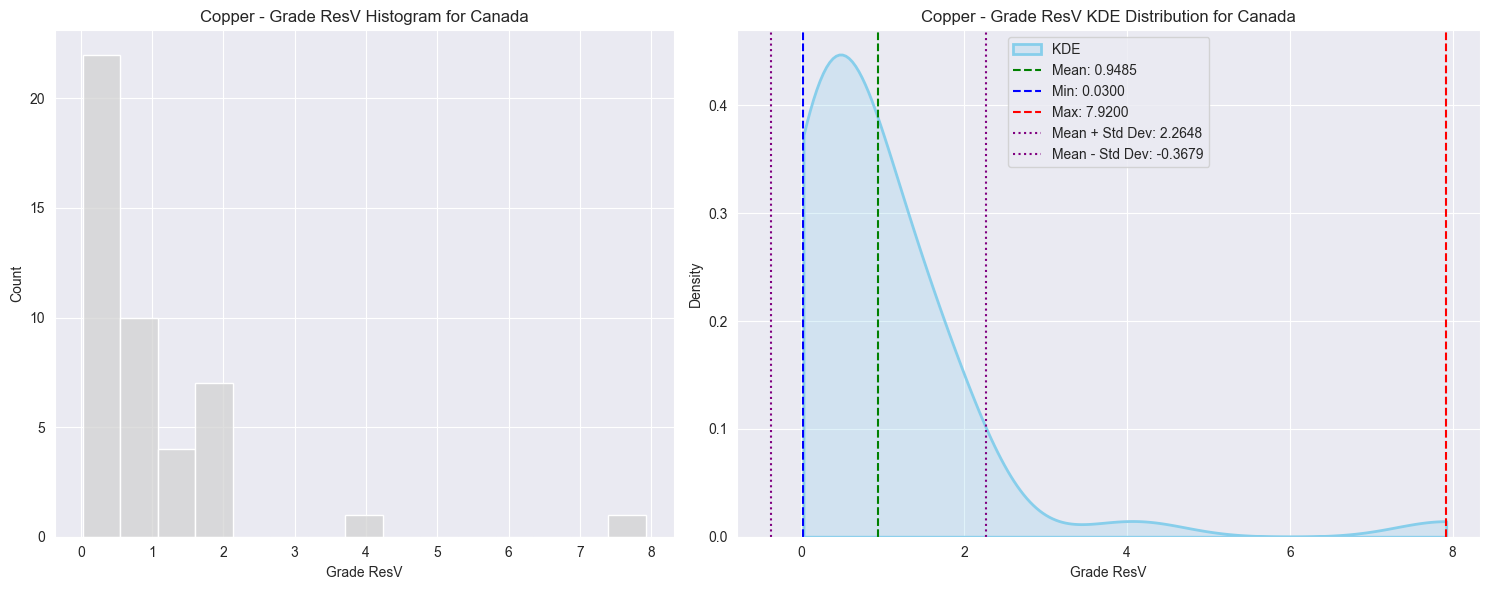

In [9]:
# Using the function for Nickel and Copper grades for all regions and Canada
nickel_resv = plot_grade_statistics(df_nickel, 'Grade ResV', 'Nickel')
copper_resv = plot_grade_statistics(df_copper, 'Grade ResV', 'Copper')
nickel_resv_can = plot_grade_statistics(df_nickel, 'Grade ResV', 'Nickel', country='Canada')
copper_resv_can = plot_grade_statistics(df_copper, 'Grade ResV', 'Copper', country='Canada')

In [ ]:
# Concatenate dfs
og_stat = pd.concat([nickel_resv, copper_resv, nickel_resv_can, copper_resv_can], ignore_index=True)

# Display the concatenated summary DataFrame
og_stat

# Storing each row in a dictionary for easy retrieval by mineral and region
ore_grade_stats = {}
for _, row in og_stat.iterrows():
    mineral = row['Mineral']
    region = row['Country']

    # Initialize dictionary for each mineral if not already present
    if mineral not in ore_grade_stats:
        ore_grade_stats[mineral] = {}

    # Store values for each region under the mineral key
    ore_grade_stats[mineral][region] = {
        'Mean': row['Mean'],
        'Min': row['Min'],
        'Max': row['Max'],
        'Std Dev': row['Std Dev']
    }

In [ ]:
# Example usage to access values:
nickel_stats = ore_grade_stats['Nickel']['All']
nickel_stats
ni_mean = 0.934864
ni_min = 0.015
ni_max = 3.99003
ni_std = 0.842238

cu_mean = 0.834055
cu_min = 0.004
cu_max = 7.92
cu_std = 0.907797
ni_can_mean = 1.3424
ni_can_min = 0.0687193
ni_can_max = 2.78839
ni_can_std = 0.818872

cu_can_mean = 0.948472
cu_can_min = 0.03
cu_can_max = 7.92
cu_can_std = 1.31636

In [ ]:
def plot_distribution_fits(df, grade_column, mineral, country=None):
    """
    Plots KDE with overlays of different distribution fits to visually assess best fit.
    
    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - mineral (str): The mineral name (e.g., "Nickel" or "Copper").
    - country (str, optional): Specific country to filter the data by.
    
    Returns:
    - None, shows the plot.
    """
    # Filter data by country if specified
    if country:
        df = df[df['Country'] == country]

    data = df[grade_column].dropna()
    mean_val, std_dev = data.mean(), data.std()
    min_val, max_val = data.min(), data.max()
    x_values = np.linspace(min_val, max_val, 100)

    # Plot KDE, restricted to valid range using clip
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data, fill=True, color='skyblue', label="KDE", linewidth=2, clip=(min_val, max_val))

    # Overlay normal distribution
    norm_pdf = norm.pdf(x_values, mean_val, std_dev)
    plt.plot(x_values, norm_pdf, 'green', linestyle='--', label="Normal")

    # Overlay log-normal distribution
    if mean_val > 0 and std_dev > 0:  # Ensure positive values for log-normal
        shape, loc, scale = lognorm.fit(data, floc=0)
        lognorm_pdf = lognorm.pdf(x_values, shape, loc=loc, scale=scale)
        plt.plot(x_values, lognorm_pdf, 'orange', linestyle='--', label="Log-normal")

    # Overlay uniform distribution
    uniform_pdf = uniform.pdf(x_values, loc=min_val, scale=(max_val - min_val))
    plt.plot(x_values, uniform_pdf, 'purple', linestyle='--', label="Uniform")

    # Overlay triangular distribution
    c = (mean_val - min_val) / (max_val - min_val) if max_val != min_val else 0.5
    triang_pdf = triang.pdf(x_values, c, loc=min_val, scale=(max_val - min_val))
    plt.plot(x_values, triang_pdf, 'blue', linestyle='--', label="Triangular")

    # Overlay beta distribution
    try:
        a, b, loc, scale = beta.fit(data, floc=min_val, fscale=(max_val - min_val))
        beta_pdf = beta.pdf(x_values, a, b, loc=loc, scale=scale)
        plt.plot(x_values, beta_pdf, 'red', linestyle='--', label="Beta")
    except ValueError:
        print("Beta distribution fitting failed due to data range constraints.")

    # Titles and labels
    plt.title(f'{mineral} - {grade_column} KDE with Distribution Fits' + (f' for {country}' if country else ''))
    plt.xlabel(grade_column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [ ]:
plot_distribution_fits(df_nickel, 'Grade ResV', 'Nickel')
plot_distribution_fits(df_copper, 'Grade ResV', 'Copper')
plot_distribution_fits(df_nickel, 'Grade ResV', 'Nickel', country='Canada')
plot_distribution_fits(df_copper, 'Grade ResV', 'Copper', country='Canada')

In [ ]:
# Adjust the function to skip beta fitting if data does not meet the requirement
def fit_and_test_distributions(df, grade_column, country=None, mineral=None):
    """
    Fits multiple theoretical distributions to the given ore grade data, 
    visualizes the data with a histogram and overlaid distribution curves, 
    and performs a Kolmogorov-Smirnov (K-S) test to assess the goodness of fit.

    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - country (str, optional): Specific country to filter the data by. If None, uses all data.

    Returns:
    - results (dict): A dictionary of K-S test results for each distribution, containing:
        - 'Statistic': The maximum difference between the empirical and theoretical cumulative distributions.
        - 'P-value': The probability that the sample data comes from the tested distribution.
        
    Notes:
    - Distributions tested include normal, log-normal, triangular, uniform, and beta (if data is within bounds).
    - Lower statistics and higher p-values indicate a better fit between the data and the tested distribution.
    """

    # Filter by country if specified
    if country:
        df = df[df['Country'] == country]

    # Drop NaN values and check if data is empty
    data = df[grade_column].dropna()
    if data.empty:
        print(f"No data available for {grade_column} in {country if country else 'all countries'}")
        return None

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=10, density=True, alpha=0.6, color='blue', label="Histogram")

    # Fit and plot normal distribution
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p_norm = norm.pdf(x, mu, std)
    plt.plot(x, p_norm, 'r-', label="Normal fit")

    # Fit and plot log-normal distribution
    shape, loc, scale = lognorm.fit(data, floc=0)
    p_lognorm = lognorm.pdf(x, shape, loc, scale)
    plt.plot(x, p_lognorm, 'g-', label="Log-normal fit")

    # Fit and plot triangular distribution
    min_val, max_val = data.min(), data.max()
    most_likely = data.mean()  # Typically mean or mode for triangular
    c = (most_likely - min_val) / (max_val - min_val) if max_val != min_val else 0.5
    p_triang = triang.pdf(x, c, loc=min_val, scale=(max_val - min_val))
    plt.plot(x, p_triang, 'b-', label="Triangular fit")

    # Fit and plot uniform distribution
    p_uniform = uniform.pdf(x, loc=min_val, scale=max_val - min_val)
    plt.plot(x, p_uniform, 'm-', label="Uniform fit")

    # Store K-S test results for valid distributions
    results = {
        'Normal': kstest(data, 'norm', args=(mu, std)),
        'Log-normal': kstest(data, 'lognorm', args=(shape, loc, scale)),
        'Triangular': kstest(data, 'triang', args=(c, min_val, max_val - min_val)),
        'Uniform': kstest(data, 'uniform', args=(min_val, max_val - min_val))
    }

    # Attempt Beta fit, skip if data is outside 0-1 range after scaling
    try:
        a, b, loc, scale = beta.fit(data, floc=min_val, fscale=max_val - min_val)
        p_beta = beta.pdf(x, a, b, loc, scale)
        plt.plot(x, p_beta, 'y-', label="Beta fit")
        results['Beta'] = kstest(data, 'beta', args=(a, b, loc, scale))
    except ValueError:
        print(f"Skipping Beta fit for {grade_column} in {country if country else 'all countries'} (data out of bounds)")

    plt.title(f'{mineral} {grade_column} Distribution Fit' + (f' for {country}' if country else ''))
    plt.xlabel(grade_column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return results

In [ ]:
# Helper function to convert K-S test results into a DataFrame for easier analysis
def extract_results_to_df(results, mineral, grade_column, country=None):
    extracted_data = []
    for dist_name, result in results.items():
        extracted_data.append({
            'Mineral': mineral,
            'Grade Column': grade_column,
            'Country': country if country else 'All',
            'Distribution': dist_name,
            'Statistic': result.statistic,
            'P-value': result.pvalue
        })
    return pd.DataFrame(extracted_data)

In [ ]:

distrib_nickel_resv = fit_and_test_distributions(df_nickel, 'Grade ResV', mineral='Nickel')
distrib_copper_resv = fit_and_test_distributions(df_copper, 'Grade ResV', mineral='Copper')
distrib_nickel_resv_can = fit_and_test_distributions(df_nickel, 'Grade ResV', country="Canada", mineral='Nickel')
distrib_copper_resv_can = fit_and_test_distributions(df_copper, 'Grade ResV', country="Canada", mineral='Copper')

# Collect all results into DataFrames if results exist
results_dfs = []
if distrib_nickel_resv: results_dfs.append(extract_results_to_df(distrib_nickel_resv, 'Nickel', 'Grade ResV'))
if distrib_copper_resv: results_dfs.append(extract_results_to_df(distrib_copper_resv, 'Copper', 'Grade ResV'))
if distrib_nickel_resv_can: results_dfs.append(
    extract_results_to_df(distrib_nickel_resv_can, 'Nickel', 'Grade ResV', country='Canada'))
if distrib_copper_resv_can: results_dfs.append(
    extract_results_to_df(distrib_copper_resv_can, 'Copper', 'Grade ResV', country='Canada'))

# Combine all results into a single DataFrame
df_all_ks_test_results = pd.concat(results_dfs, ignore_index=True)
df_all_ks_test_results


NormalDistribution(nickel) and LogNormalDistribution(copper) appear to be a good fit

In [ ]:
# If log-normal distribution is chosen, we need those formulas to calculate the mean and std
cu_mean_log = np.log(cu_mean / np.sqrt(1 + (cu_std / cu_mean) ** 2))
cu_std_log = np.sqrt(np.log(1 + (cu_std / cu_mean) ** 2))

# Relationship between variables

Ore grade decline are observed for copper, zinc, lead and nickel in Van der Voet et al (2019). 10.1111/jiec.12722, who takes information from various sources (Mudd et al. (2017), Crowson (2012), Mudd & Jowit (2013), Northey et al. (2014) and Mudd et al. (2013)). 

The energy ore grade relation defines how energy inputs change as a function of the
ore grade. Instead of developing a function for each individual input and output, the energy change often serve as a proxy for the change of other inputs
and outputs. 

Thus, we model the effects of ore grade decline on the mining process
by applying the percentage energy change to all other input and output values. The only process affected by an ore grade decline is the metal mine operation.

- 1 - Definition of future ore grades G(t) and G(t0) for base years
- 2 - Definition of energy requirements E(G) based on the energy-ore relation from literature
- 3 - Calculate a percentage change p(t) between the base year and the future years
- 4 - Calculate modelling factor, which is applied to outflows of mining processes in ecoivent to model how inputs and outputs of mining processes change

In [ ]:
### Ore grade ###
def ore_grade_decline(t, a, b):
    """
    Calculate the ore grade at a given time based on a power regression model.

    Parameters:
    - t (float or np.array): Time in years (e.g., since a baseline year).
    - a (float): Constant for the initial ore grade level.
    - b (float): Exponent that defines the rate of ore grade decline.

    Returns:
    - float or np.array: Estimated ore grade at time t.
    """
    return a * (t ** b)


def energy_ore_grade(ore_grade, r, q):
    """
    Calculate the energy requirement based on ore grade. 

    Parameters:
    - ore_grade (float or np.array): The ore grade value(s), e.g., in percentage or fraction.
    - r (float): Constant for energy-ore grade relation, specific to the metal.
    - q (float): Exponent that defines sensitivity of energy to ore grade changes.

    Returns:
    - float or np.array: Energy requirement (MJ/kg) based on ore grade.
    """
    return r * np.power(ore_grade, q)


def future_energy_requirement(t, c, d):
    """
    Calculate the energy requirement over time as ore grades decline.

    Parameters:
    - t (float or np.array): Time in years (e.g., years since baseline).
    - c (float): Constant for the initial energy requirement.
    - d (float): Exponent that defines the growth of energy requirements over time.

    Returns:
    - float or np.array: Projected energy requirement (MJ/kg) at time t.
    """
    return c * (t ** d)


def percentage_change_energy(E_t, E_0):
    """
    Calculate the percentage change in energy requirements over time.

    Parameters:
    - E_t (float or np.array): Future energy requirement (MJ/kg) at time t.
    - E_0 (float): Baseline energy requirement (MJ/kg) at a reference year.

    Returns:
    - float or np.array: Percentage increase in energy requirements relative to baseline.
    """
    return (E_t - E_0) / E_0


def modeling_factor(E_0, E_t):
    """
    Calculate the modeling factor to scale energy requirements in LCA models.

    Parameters:
    - E_0 (float): Baseline energy requirement (MJ/kg) at the reference year.
    - E_t (float or np.array): Future energy requirement (MJ/kg) at time t.

    Returns:
    - float or np.array: Modeling factor for scaling energy in LCA.
    """
    return E_0 / E_t

In [ ]:
# From Van der Voelt (2019), who source it from Valero et al. (2011); Norgate and Jahanshahi (2006) Northey et al. (2014)
r_cu = 15.63
q_cu = -0.53

r_zinc = 77.65 
q_zinc = -1

r_pb = 75.42
q_pb = -1

r_ni_sulfide = 198.22
q_ni_sulfide = -0.406

r_ni_sulfide = 194.9
q_ni_sulfide = -0.494

In [ ]:
def calculate_energy_input(mine_depth, ore_grade, a, c, b):
    """
    Calculate energy input (MJ per kg of copper) for copper mining and milling.
    Based on Koppelaar & Koppelaar (2016)

    This function is based on a statistically derived equation that relates energy costs
    to ore grade and mine depth. It assumes a linear relationship with depth and a 
    reciprocal relationship with ore grade.

    Equation:
        E = a + c * D + (b / G)

    Parameters:
    -----------
    mine_depth : float
        The depth of the mine in meters (D).
    ore_grade : float
        The ore grade as a decimal percentage (e.g., 0.5 for 0.5% ore grade).
    a : float
        The baseline energy input (MJ/kg) for zero depth and infinite ore grade.
    c : float
        The coefficient representing the energy increase per meter of depth (MJ/kg per meter).
    b : float
        The coefficient representing the energy cost associated with ore grade (MJ/kg).

    Returns:
    --------
    float
        The calculated energy input in MJ per kg of copper concentrate.

    Raises:
    -------
    ValueError:
        If ore_grade is less than or equal to zero, as it results in division by zero.
    
    Example:
    --------
    >>> energy_input = calculate_energy_input(mine_depth=450, ore_grade=0.5, a=1.463, c=0.000374, b=0.0119)
    >>> print(energy_input)
    52.874 MJ/kg
    """
    if ore_grade <= 0:
        raise ValueError("Ore grade must be greater than zero to avoid division by zero.")
    
    # Apply the equation
    energy_input = a + c * mine_depth + (b / ore_grade)
    
    return energy_input

# Example usage
if __name__ == "__main__":
    # Input parameters
    mine_depth = 450        # Depth in meters
    ore_grade = 0.5         # Ore grade as a percentage (e.g., 0.5% => 0.5)
    a = 1.463               # Baseline energy cost (MJ/kg)
    c = 0.000374            # Energy cost increase per meter depth (MJ/kg per meter)
    b = 0.0119              # Energy cost factor for ore grade (MJ/kg)

    # Calculate energy input
    energy_cost = calculate_energy_input(mine_depth, ore_grade, a, c, b)
    print(f"Energy input for copper production: {energy_cost:.2f} MJ/kg")


In [ ]:
def calculate_rmr(ore_mined, waste_removed, mineral_produced, refinery_recovery_rate, unit_price):
    """
    Calculate the Rock-to-Metal Ratio (RMR) for a given mineral commodity and operations.
    Equations from Nassar et al (2022)

    Parameters:
    - ore_mined (list of floats): Quantity of ore mined at each operation (O_i,j).
    - waste_removed (list of floats): Quantity of waste rock removed at each operation (W_i,j).
    - mineral_produced (list of floats): Quantity of mineral produced (M_i,j).
    - refinery_recovery_rate (list of floats): Recovery rate at smelting/refining stage (R_i,j).
    - unit_price (list of floats): Realized unit price of the commodity (P_i,j).

    Returns:
    - float: The Rock-to-Metal Ratio (RMR).
    """
    if not (len(ore_mined) == len(waste_removed) == len(mineral_produced) == len(refinery_recovery_rate) == len(unit_price)):
        raise ValueError("All input lists must have the same length.")
    
    numerator = 0
    denominator = 0
    
    for O, W, M, R, P in zip(ore_mined, waste_removed, mineral_produced, refinery_recovery_rate, unit_price):
        numerator += (O + W) * P
        denominator += M * R * P
    
    if denominator == 0:
        raise ZeroDivisionError("Denominator (total recoverable metal weighted by price) cannot be zero.")
    
    rmr = numerator / denominator
    return rmr

# Example usage
ore_mined = [1000, 2000, 1500]  # Ore mined at 3 operations
waste_removed = [500, 700, 600]  # Waste rock removed
mineral_produced = [100, 150, 120]  # Mineral commodity produced
refinery_recovery_rate = [0.9, 0.85, 0.88]  # Recovery rate at smelting/refining
unit_price = [50, 55, 52]  # Unit price of the commodity

rmr = calculate_rmr(ore_mined, waste_removed, mineral_produced, refinery_recovery_rate, unit_price)
print("Rock-to-Metal Ratio (RMR):", rmr)


In [ ]:
def calculate_bth_ratios(byproduct_quantity, host_quantity, recovery_rate_byproduct, recovery_rate_host, max_recovery_rate_byproduct=None, max_recovery_rate_host=None):
    """
    Calculate the Available, Accessible, and Potentially Accessible Byproduct-to-Host (BtH) Ratios.
    Described in Greffe et al (2024)

    Parameters:
    - byproduct_quantity (float): Quantity of the byproduct in the deposit (B1,d).
    - host_quantity (float): Quantity of the host element in the deposit (H1,d).
    - recovery_rate_byproduct (float): Current recovery rate of the byproduct (% as decimal).
    - recovery_rate_host (float): Current recovery rate of the host element (% as decimal).
    - max_recovery_rate_byproduct (float, optional): Theoretical maximum recovery rate of the byproduct (% as decimal).
    - max_recovery_rate_host (float, optional): Theoretical maximum recovery rate of the host element (% as decimal).

    Returns:
    - dict: A dictionary with 'available', 'accessible', and 'potentially_accessible' BtH ratios.
    """
    if host_quantity <= 0:
        raise ValueError("Host quantity must be greater than zero.")
    if not (0 <= recovery_rate_byproduct <= 1) or not (0 <= recovery_rate_host <= 1):
        raise ValueError("Recovery rates must be between 0 and 1.")
    
    # Available BtH ratio
    bth_available = byproduct_quantity / host_quantity
    
    # Accessible BtH ratio
    bth_accessible = (byproduct_quantity * recovery_rate_byproduct) / (host_quantity * recovery_rate_host)
    
    # Potentially Accessible BtH ratio (if max recovery rates are provided)
    if max_recovery_rate_byproduct and max_recovery_rate_host:
        if not (0 <= max_recovery_rate_byproduct <= 1) or not (0 <= max_recovery_rate_host <= 1):
            raise ValueError("Max recovery rates must be between 0 and 1.")
        bth_potentially_accessible = (byproduct_quantity * max_recovery_rate_byproduct) / (host_quantity * max_recovery_rate_host)
    else:
        bth_potentially_accessible = None
    
    return {
        "available": bth_available,
        "accessible": bth_accessible,
        "potentially_accessible": bth_potentially_accessible
    }

# Example usage:
byproduct_quantity = 1000  # Example: 1000 tons of byproduct
host_quantity = 5000       # Example: 5000 tons of host
recovery_rate_byproduct = 0.8  # 80% current recovery rate for the byproduct
recovery_rate_host = 0.95      # 95% current recovery rate for the host
max_recovery_rate_byproduct = 0.9  # 90% max theoretical recovery rate
max_recovery_rate_host = 0.97      # 97% max theoretical recovery rate

ratios = calculate_bth_ratios(
    byproduct_quantity, 
    host_quantity, 
    recovery_rate_byproduct, 
    recovery_rate_host,
    max_recovery_rate_byproduct, 
    max_recovery_rate_host
)
print("BtH Ratios:", ratios)
